In [1]:
import os
import random
import numpy as np

SEED = 42

# Reproducibilidad Python
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Control de hilos antes de importar TensorFlow
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "1"
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "1"

In [2]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Embedding, LayerNormalization, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D, Concatenate as KConcat
)

In [3]:
# Recuperar el mismo DataFrame
with open('dfe_guardado.pkl', 'rb') as e:
    dfe = pickle.load(e)
dfa = dfe.copy()

In [4]:
# Eliminar dos coliumnas que no utilizaremos
dfa = dfa.drop(['goles_local', 'goles_visitante'], axis=1)

In [5]:
SEED = 42
np.random.seed(SEED)      # Fija la semilla para NumPy
tf.random.set_seed(SEED)  # Fija la semilla para TensorFlow

In [6]:
# Definir columnas por tipo de datos y objetivo
categorical_cols = ['ronda', 'equipo_local', 'equipo_visitante']  # embeddings
numeric_cols = ['torneo', 'semestre', 'fecha_torneo']
target_col = 'resultado'  # valores: 'LOCAL','EMPATE','VISITANTE'

In [7]:
# Codificar la variable objetico en numeros para facilitar el procesamiento
le_target = LabelEncoder()
dfa['target_enc'] = le_target.fit_transform(dfa[target_col])  # 0,1,2 por ejemplo
class_names = le_target.classes_.tolist()  # ['EMPATE','LOCAL','VISITANTE'] orden depende de fit


In [8]:
# Codificar las variables categoricas en numeros para facilitar el procesamiento
cat_label_encoders = {}
for c in categorical_cols:
    le = LabelEncoder()
    dfa[c + "_enc"] = le.fit_transform(dfa[c].astype(str))
    cat_label_encoders[c] = le


In [9]:
# Asegura que todas las variables numericas aportan de manera equilibrada al entrenar el modelo
scaler_num = StandardScaler()
dfa_num = scaler_num.fit_transform(dfa[numeric_cols].astype(float))


In [10]:
# Crear el arreglo para entradas categoricas y numericas y preparar los tensores de entrada

X_cat = np.stack([dfa[c + "_enc"].values for c in categorical_cols], axis=1) 
X_num = dfa_num  # shape (N, num_num)
y = dfa['target_enc'].values
num_classes = len(np.unique(y))

In [11]:
# Dividir el conjunto de datos en pruebas
Xc_train, Xc_test, Xn_train, Xn_test, y_train, y_test = train_test_split(
    X_cat, X_num, y, test_size=0.30, random_state=SEED, shuffle=True, stratify=y
)

In [12]:
# Configuración de hiperparametros y dimesiones clave para construir un transformer Tabtransformer
num_categorical = X_cat.shape[1]      
num_numeric = X_num.shape[1]
embedding_dim = 16  # se selecciona debido a que hay posible 20 a 25 categorias
num_heads = 2
ff_dim = 32   
dropout_rate = 0.2

# Para cada categoria, necesitamos el tamaño
vocab_sizes = [ int(dfa[c].nunique()) + 1 for c in categorical_cols ]

In [13]:
# Contrucción del TabTransformer con Keras

cat_inputs = [Input(shape=(1,), dtype='int32', name=f"cat_{c}") for c in categorical_cols]
num_input = Input(shape=(num_numeric,), dtype='float32', name='numerics')

# Embeddings por columna -> se concatenan para formar la "secuencia"
embeddings = []
for i, inp in enumerate(cat_inputs):
    vsize = vocab_sizes[i]
    emb = Embedding(input_dim=vsize, output_dim=embedding_dim, name=f"emb_{i}")(inp)  # (batch,1,emb)
    embeddings.append(emb)

# Concatenate embeddings -> (batch, seq_len, emb_dim)

seq_emb = KConcat(axis=1)(embeddings)  # shape (batch, num_categorical, embedding_dim)

In [14]:
# Codigo para que el modelo aprenda de forma mas estable y precisa
seq_emb = LayerNormalization()(seq_emb)

# Modelo aprenda relaciones entre variables
attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(seq_emb, seq_emb)
attn = LayerNormalization()(attn)
attn = Dropout(dropout_rate)(attn)

# modelo aprenda representaciones profundas
ff = Dense(ff_dim, activation='relu')(attn)
ff = Dropout(dropout_rate)(ff)
ff = LayerNormalization()(ff)

# Genrar vector que representa toda la información de varialbes categoricas
pooled = GlobalAveragePooling1D()(ff) 

# Integrar las caracteristcas del data set en un unico vector
concat = KConcat()([pooled, num_input])

In [15]:
# Head clasificador
x = Dense(32, activation='relu')(concat)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=cat_inputs + [num_input], outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cat_ronda (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_equipo_local (InputLayer) │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_equipo_visitante          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emb_0 (Embedding)             │ (None, 1, 16)             │              64 │ cat_ronda[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emb_1 (Embedding)             │ (None, 1, 16)             │             416 │ cat_equipo_local[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emb_2 (Embedding)             │ (None, 1, 16)             │             416 │ cat_equipo_visitante[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 3, 16)             │               0 │ emb_0[0][0], emb_1[0][0],  │
│                               │                           │                 │ emb_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 3, 16)             │              32 │ concatenate[0][0]          │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 3, 16)             │           2,160 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 3, 16)             │              32 │ multi_head_attention[0][0] │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 3, 16)             │               0 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 3, 32)             │             544 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 3, 32)             │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 3, 32)             │              64 │ dropout_2[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,459 (21.32 KB)

 Trainable params: 5,459 (21.32 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Preparar datos para Keras (inputs por tensor)

def build_model_inputs(Xc, Xn):
    # Xc shape (N, num_cat), Xn shape (N, num_num)
    inputs = {}
    for i, c in enumerate(categorical_cols):
        inputs[f"cat_{c}"] = Xc[:, i]
    inputs['numerics'] = Xn
    return inputs

train_inputs = build_model_inputs(Xc_train, Xn_train)
test_inputs = build_model_inputs(Xc_test, Xn_test)


In [17]:
# Pesos de clase (si hay desbalance)

classes = np.unique(y_train)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Revisar distribución y pesos
unique, counts = np.unique(y_train, return_counts=True)

df_weights = pd.DataFrame({"Clase": classes, "Count": counts, "Peso": class_weights})
print(df_weights)


   Clase  Count      Peso
0      0    460  1.112319
1      1    703  0.727833
2      2    372  1.375448


In [18]:
# Entrenar el modelo con Tabtransformers
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_path = "tabtransformer_best.keras"
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    train_inputs, y_train,
    validation_split=0.15,
    epochs=30,
    batch_size=32,
    callbacks=[es, mc],
    class_weight=class_weight_dict,
    shuffle=False, 
    verbose=1
)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.3926 - loss: 1.1448 - val_accuracy: 0.3506 - val_loss: 1.0943
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3459 - loss: 1.1027 - val_accuracy: 0.3636 - val_loss: 1.0891
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3704 - loss: 1.0968 - val_accuracy: 0.3593 - val_loss: 1.0885
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3742 - loss: 1.0832 - val_accuracy: 0.3550 - val_loss: 1.0904
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3873 - loss: 1.0851 - val_accuracy: 0.4113 - val_loss: 1.0841
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4256 - loss: 1.0651 - val_accuracy: 0.4329 - val_loss: 1.0900
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4233 - loss: 1.0712 - val_accuracy: 0.3766 - val_loss: 1.0997
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4241 - loss: 1.0699 - val_accuracy: 0.3636 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step  
Accuracy (test): 0.39209726443769

Classification report:
               precision    recall  f1-score   support

      EMPATE       0.27      0.23      0.25       197
       LOCAL       0.51      0.57      0.54       301
   VISITANTE       0.27      0.26      0.26       160

    accuracy                           0.39       658
   macro avg       0.35      0.35      0.35       658
weighted avg       0.38      0.39      0.38       658


Confusion matrix:
 [[ 45  96  56]
 [ 72 172  57]
 [ 48  71  41]]


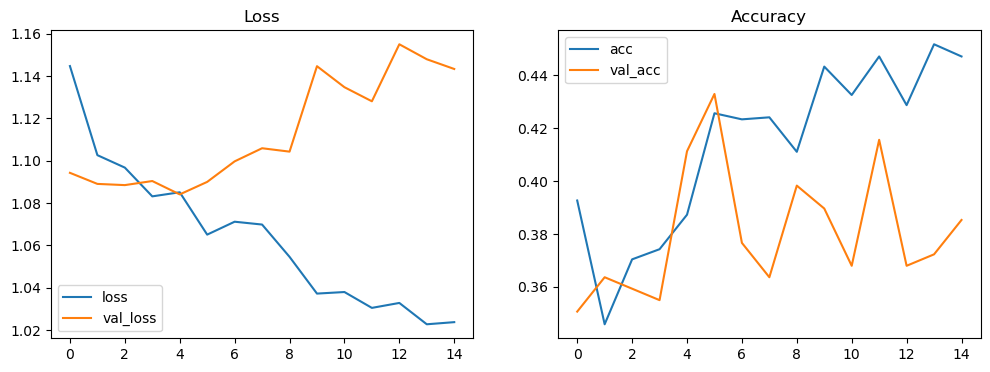

In [19]:

# Metricas y evaluación del modelo

# Predicciones
y_pred_proba = model.predict(test_inputs)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Accuracy (test):", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)

# ----------------------------
# 12) Graficar curvas de entrenamiento y matriz de confusión
# ----------------------------
# Loss & Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.show()


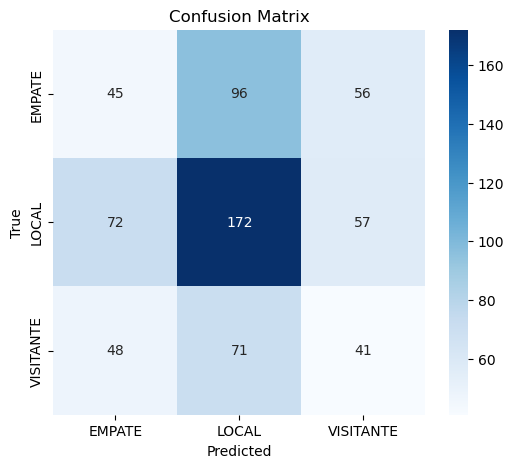

In [20]:
# Matriz de confusión (heatmap)
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Generar le bot predicitivo
def predecir_partido_simple(model, equipo_local, equipo_visitante, ronda):
    # Valores numéricos por defecto (pueden ser cualquier número, aquí usamos 0)
    numerics_dict = {'torneo': 0, 'semestre': 0, 'fecha_torneo': 0}

    # Construir inputs
    input_dict = {}
    input_dict['cat_equipo_local'] = cat_label_encoders['equipo_local'].transform([equipo_local])[0]
    input_dict['cat_equipo_visitante'] = cat_label_encoders['equipo_visitante'].transform([equipo_visitante])[0]
    input_dict['cat_ronda'] = cat_label_encoders['ronda'].transform([ronda])[0]
    input_dict['numerics'] = np.array([list(numerics_dict.values())], dtype=float)

    # Preparar input para el modelo
    model_input = {k: (v if k=='numerics' else np.array([v])) for k,v in input_dict.items()}

    # Predicción
    proba = model.predict(model_input, verbose=0)
    pred_class = np.argmax(proba, axis=1)[0]

    # Mostrar resultado
    print(f"\n-----Partido: {equipo_local} vs {equipo_visitante} | Ronda: {ronda}")
    print("Resultado probable:", class_names[pred_class])
    print("\nProbabilidades:")
    for i, cname in enumerate(class_names):
        print(f"{cname}: {proba[0][i]*100:.2f}%")
    
    return pred_class

In [22]:
# Ejemplo de uso
predecir_partido_simple(model, "junior", "nacional", "INICIAL")


🔹 Partido: junior vs nacional | Ronda: INICIAL
Resultado probable: EMPATE

Probabilidades:
EMPATE: 34.79%
LOCAL: 32.50%
VISITANTE: 32.71%


np.int64(0)

# 